In [99]:
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

import numpy as np
from htmresearch.support.cans.utils import *
from htmresearch.support.cans.basic_dynamics import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


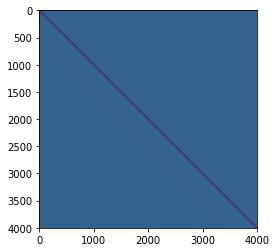

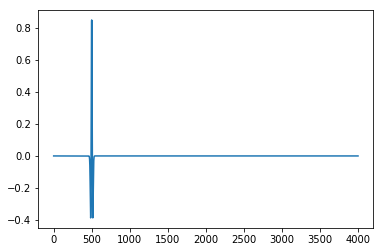

In [319]:


r = 500.
n = 4000  
m = 200   

X = np.linspace(0.,r, num=n)


D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
            D[i,j] = np.absolute(X[i] - X[j])

        
J = mexican_hat
# W = create_W(J, D, normalize=True)

# J = W_zero
W_rec = create_recurrent_weights(J, D, normalize=False)



# W[W>0]=0.

plt.imshow(W_rec)
plt.show()

plt.plot(W_rec[500])
plt.show()

# tonic = - np.mean(W[:,:], axis=1)
# plt.plot(tonic)



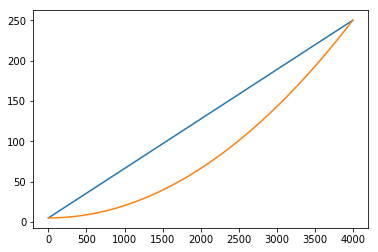

In [320]:

max_boost = 250.
min_boost = 5.

boost_mask = (max_boost- min_boost)*np.linspace(0.,1.,num=n)**2 + min_boost

plt.plot(np.linspace(min_boost,max_boost,num=n))
plt.plot(boost_mask)
plt.show()


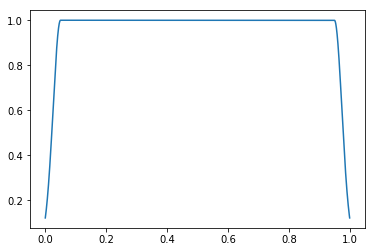

In [321]:
A = create_envelope(n, steepness=2.1, delta=0.05);
# A = np.ones(n)
plt.plot(np.linspace(0.,1.,n),A);

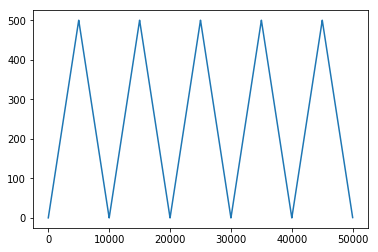

In [322]:
T = 50000




def bump(mu):
    x = np.linspace(0., r, num=m)
    return np.exp(-(x - mu)**2/0.1)

X = np.zeros((T,m))
mu=0.0
trail = []
sign = 1.
for t in range(T):
#     if np.random.sample() < 0.001:
#         sign *= -1
#     if t%1000 ==0:
#         sign *= -1.
    mu += sign * 0.1
#     mu = mu%r
    if mu > r or mu <0:
        sign *= -1.
    X[t] = bump(mu)
    trail.append(mu)

# plt.plot(bump(0.5*r))
plt.plot(trail)


<Figure size 1440x360 with 0 Axes>

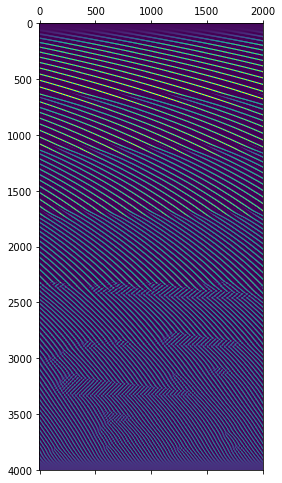

In [323]:
np.seterr(invalid='raise')

W_fwrd = np.zeros((n, m))
eta = 0.001


S    = np.zeros((T,n))
S[0] = np.random.sample(n)*0.001

boost = np.zeros(n)
s_avg = np.zeros(n) 
x_avg = np.zeros(m) 



for t in range(1,T):
    tonic = 0.005 
    s = S[t-1]
    x = np.zeros(m)
#     x = X[t]
    b = np.dot(W_fwrd, x) + tonic + boost_mask*boost

    s_   = evolve(W_rec, b, s, A)  
    S[t] = s_


    alpha_boost = 0.01
    boost = (1. - alpha_boost)*boost - alpha_boost*(s_ - np.mean(s_))
#     boost = boost - (s_ - np.mean(s_))
    

    alpha_x = 0.9
    alpha_s = 0.8
    
    
#     dW_fwrd  = eta*( np.outer(s_, x) - np.outer(s_avg, x_avg) )

#     x_avg = (1. - alpha_x)*x_avg + alpha_x*x
#     s_avg = (1. - alpha_s)*s_avg + alpha_s*s_

    
#     W_fwrd   = 0.9999*W_fwrd + dW_fwrd 
#     W_fwrd  += dW_fwrd 
#     W_fwrd   = np.maximum(W_fwrd, 0.)


plt.figure(figsize=(20,5))
plt.matshow(S[-2000:].T)
plt.show()





<Figure size 2160x1440 with 0 Axes>

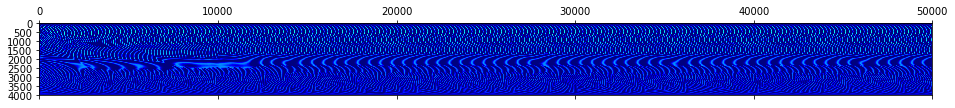

In [324]:
plt.figure(figsize=(30,20))
plt.matshow(S[0:].T, cmap="jet")
plt.show()



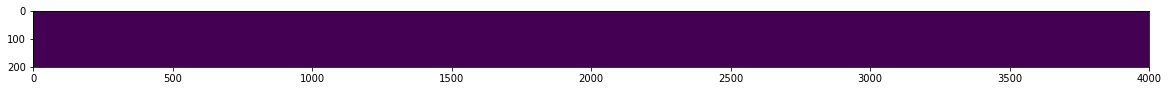

In [303]:


# S = np.clip(S, 0.,np.max(S[8000]))
plt.figure(figsize=(20,5))
plt.imshow(W_fwrd[:].T > 0.)
plt.show()



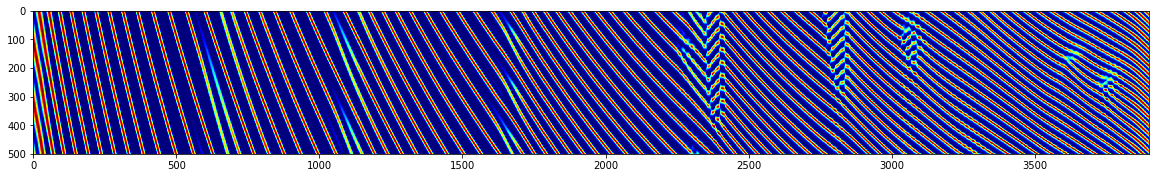

(3900,) 4000


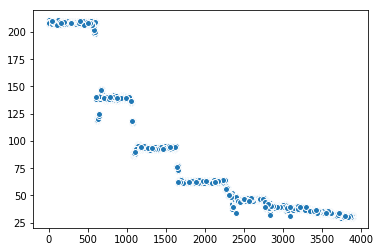

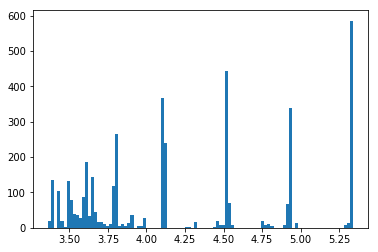

In [333]:




def compute_scales(W):
    gc     = W.shape[1]
    scales = np.zeros(gc)
    for i in range(gc):
        f = (W[:,i] > 0.2).astype(float)
        df = f[1:] - f[:-1]
        ind = np.where(df == -1.)[0]
        ind = ind.astype(float)
        if len(ind) > 1:
            scales[i] = np.mean(ind[1:] - ind[:-1])
        else:
            scales[i] = -100

    return scales


# plt.style.use('ggplot')

S_ = S[:]
# S_ = S/np.amax(S, axis=1, keepdims=True)


plt.figure(figsize=(20,5))
patch = S_[-500:, 50:-50]

patch = patch - np.amin(patch, axis=0, keepdims=True)
patch = patch/np.amax(patch, axis=0, keepdims=True)
plt.imshow(patch, cmap="jet")
plt.show()



scales = compute_scales(patch)

np.clip(scales, -1,400,scales)
print scales.shape, n
perm = np.random.permutation(n-100)
plt.scatter(np.arange(n-100)[perm], scales[perm] + np.random.sample(n-100)*3., edgecolor="white")
plt.show()
vals, bins, _ = plt.hist(np.log(scales), bins=100);


In [328]:

sorted_ind = np.argsort(vals)[::-1]
arr = np.sort(bins[sorted_ind][:6])

print arr
for i in range(1, len(arr)):
    print i,arr[i]/arr[i-1]

[  29.13333333   38.67666667   59.672        90.21066667  137.92733333
  206.63933333]
1 1.32757437071
2 1.54284236835
3 1.51177548376
4 1.52894705726
5 1.49817536771


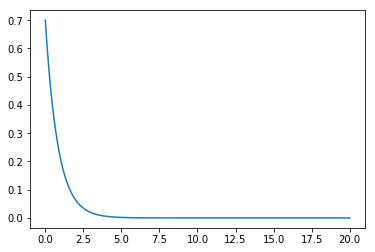

In [306]:
tau = np.linspace(0.,20., num=10000)

alpha = 0.7
plt.plot(tau, alpha*(1-alpha)**tau)

<Figure size 1440x360 with 0 Axes>

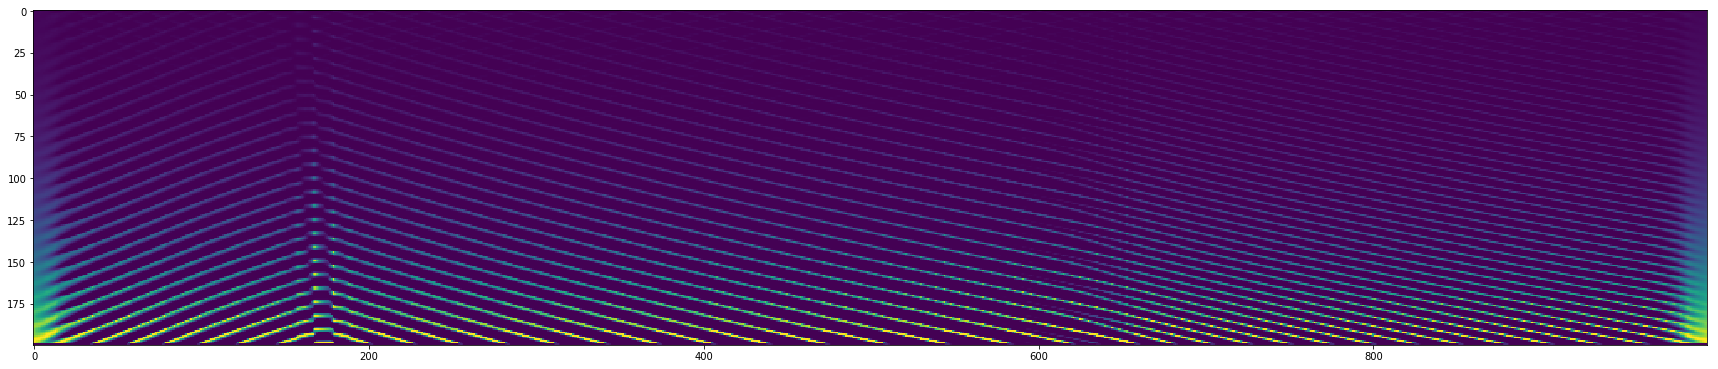

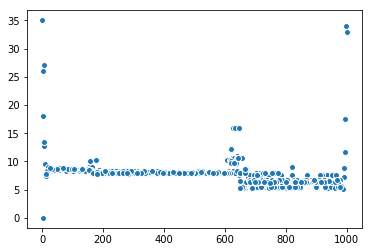

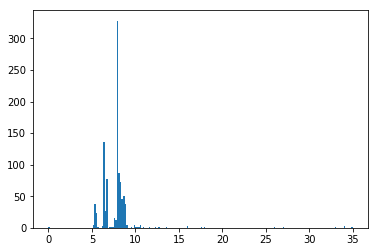

In [28]:




def compute_scales(W):
    gc     = W.shape[1]
    scales = np.zeros(gc)
    for i in range(gc):
        f = (W[:,i] > 0.5).astype(float)
        df = f[1:] - f[:-1]
        ind = np.where(df == -1.)[0]
        ind = ind.astype(float)
        if len(ind) > 1:
            scales[i] = np.mean(ind[1:] - ind[:-1])
        else:
            scales[i] = 0

    return scales


# plt.style.use('ggplot')

# S_ = S[]


plt.figure(figsize=(20,5))
W_ = W_fwrd/np.max(W_fwrd, axis=1, keepdims=True)
patch = W_.T


plt.figure(figsize=(30,20))
plt.imshow(patch)
plt.show()


scales = compute_scales(patch)



perm = np.random.permutation(n)
plt.scatter(np.arange(n)[perm], scales[perm], edgecolor="white")
plt.show()
plt.hist(scales, bins=200);


100